In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, N_syl, N_HVC_per_syl = 600, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 8 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# plt.plot(rH[:T_rend+T_burn])
# plt.plot(tsyl_start[:,0], np.zeros(N_syl) + peak_rate, 'x', c='r')
# plt.plot(tsyl_end[:,0], np.zeros(N_syl) + peak_rate, 'x', c='b')
# plt.plot(burst_ts[:,0], np.zeros(N_HVC) + peak_rate, '|', c='k')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
r_rest = 2 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [10]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 0.5) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [11]:
w0_mean = 1/N_HVC
w_inh = w0_mean
tauE, dt = 40, 1

net = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh)

rE0 = r_rest
_ = net.sim(rE0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-5e-2, w0_mean=w0_mean, tauW=1e5)
rE, _, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


100%|█████████████████████████████████████| 5299/5299 [00:01<00:00, 2779.56it/s]


(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean exc. rate'>],
       dtype=object))

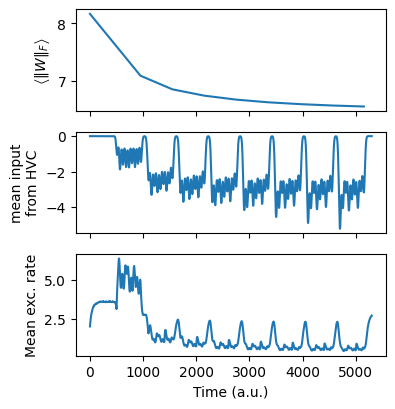

In [12]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts)

In [13]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

(<Figure size 600x200 with 4 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}, ylabel='HVC index'>,
        <Axes: title={'center': 'Rendition 4'}>,
        <Axes: title={'center': 'Rendition 8'}>], dtype=object))

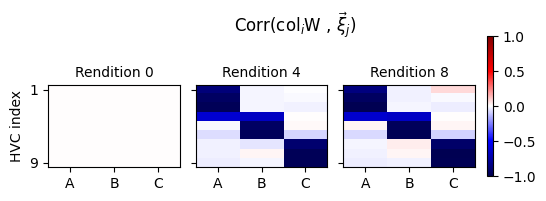

In [14]:
plot_wcol_corr(W_syl_corrs, (1, 3), (6, 2))

(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle |\\Delta W_{ij}|\\right\\rangle_i$'>,
        <Axes: ylabel='weight corr.\nabs. change'>,
        <Axes: ylabel='$\\left\\langle |r^E - r^E_0| \\right\\rangle$'>],
       dtype=object))

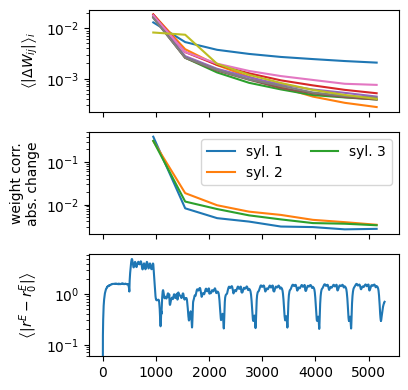

In [15]:
plot_train_converge(Ws, W_syl_corrs, save_W_ts, rE, r_rest)

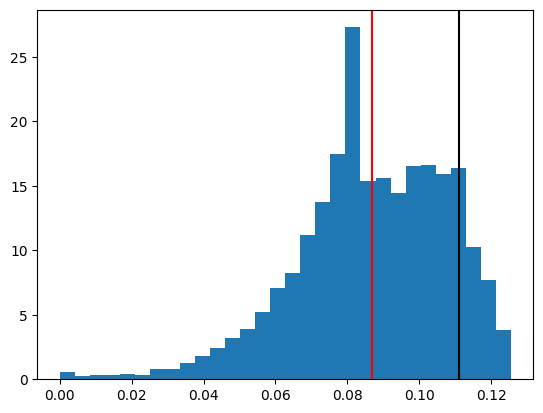

In [16]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Test Model with Unmatched Auditory Feedback

In [17]:
N_rend_test = 1
T_test = T_burn + T_rend * N_rend_test
t_test_start, t_test_end = tsyl_start[:,:N_rend_test], tsyl_end[:,:N_rend_test]
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH_ = generate_HVC(T_test, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
rH_null = np.zeros_like(rH_)
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
noise = 1

### Mismatch with completely independent patterns

In [18]:
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns (randomize)
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
syl_si = syl[idx_si]
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_si)
aud_sp = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_sp)
aud_pb = aud[:T_test].copy()
aud_si[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_sp[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_pb[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_df = rng.normal(0, 1, size=aud_si.shape)

In [19]:
test_names = ('Singing\ncorrect', 'Singing\nshuf. index', 
              'Singing\nshuf. pattern', 'Playback\n', 'Singing\ndeafen')
# plasticity function is None and lr is 0 by default
test0 = net.sim(rE0, rH_, aud[:T_test], [], T_test, dt, noise)
test_si = net.sim(rE0, rH_, aud_si, [], T_test, dt, noise)
test_sp = net.sim(rE0, rH_, aud_sp, [], T_test, dt, noise)
test_pb = net.sim(rE0, rH_null, aud_pb, [], T_test, dt, noise)
test_df = net.sim(rE0, rH_, aud_df, [], T_test, dt, noise)
# just want rE and rI
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2]
test_pb, test_df = test_pb[:2], test_df[:2]
tests_all = (test0, test_si, test_sp, test_pb, test_df)

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 13855.03it/s]


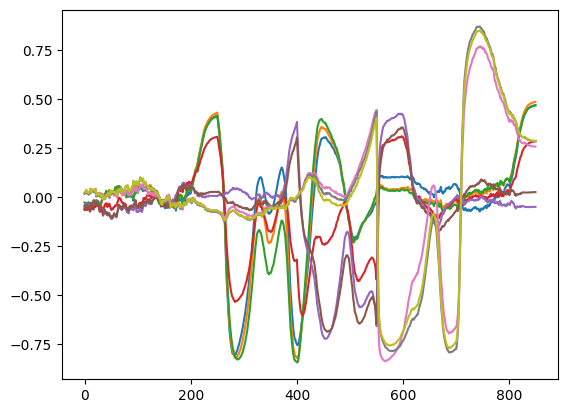

In [20]:
ti, tj = T_burn//2, T_burn + T_rend
plt.plot(correlation(test0[0][ti:tj], Ws[-1].T, dim=2));

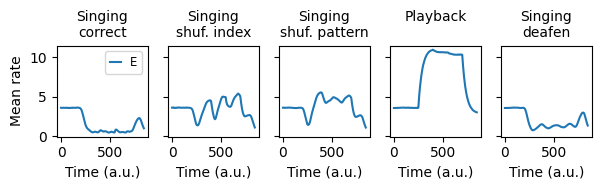

In [21]:
ti, tj = T_burn//2, T_burn + T_rend
fig, ax = plot_tests_mean(tests_all, test_names, ti, tj, plot_inh=False)

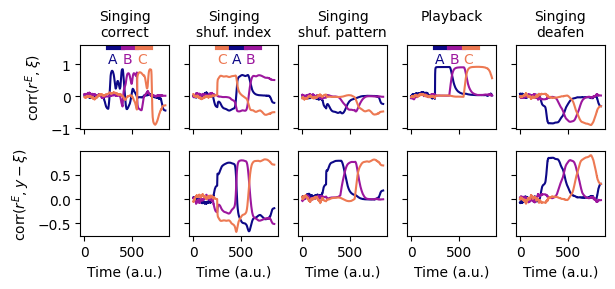

In [22]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-shuffled
fig, ax = plot_tests_corrs(tests_all, (syl, syl_si, syl_sp, syl, None), syl, test_names,
                           ti, tj, tid_perturb_input=(1, 2, 4), 
                           syl_order={1: [(j, *ts[i]) for i, j in enumerate(idx_si)],
                                      0: aux, 3: aux}, y=1.5)

0 600


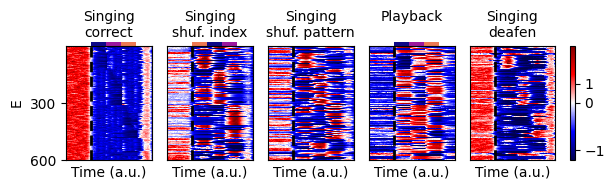

In [23]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, ti, tj, T_burn, 
                            syl_order={1: [(j, *ts[i]) for i, j in enumerate(idx_si)],
                                      0: aux, 3: aux})

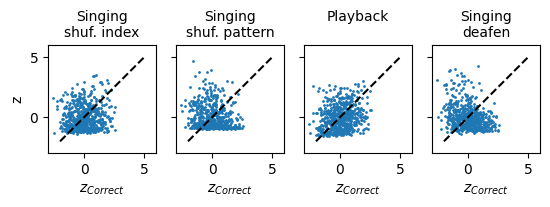

In [24]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all, test_names, ti, tj)

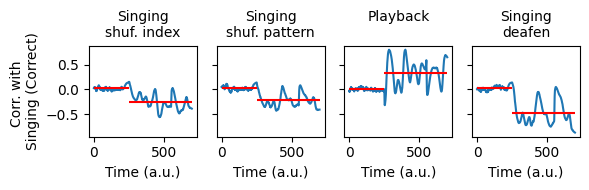

In [25]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all, test_names, ti, tj, T_burn)

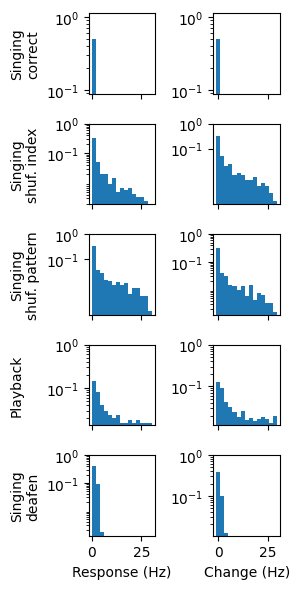

In [26]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all, test_names, ti, tj)

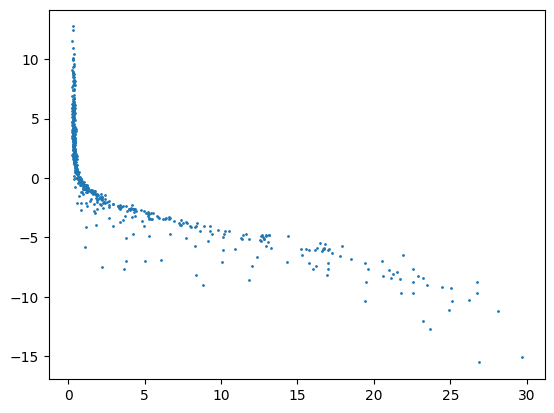

In [27]:
plt.plot(test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0], 'o', ms=1)

In [28]:
# Mutual Information
r, x = test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0]
joint_p = np.histogram2d(x, r, bins=50, density=True) # row is vertical dim.
joint_p[0][:] += 1e-10
p_r = np.histogram(r, bins=joint_p[2], density=True)
p_r[0][:] += 1e-10
p_x = np.histogram(x, bins=joint_p[1], density=True)
p_x[0][:] += 1e-10
dr, dx = joint_p[2][1] - joint_p[2][0], joint_p[1][1] - joint_p[1][0]
h_x_given_r = -np.sum(joint_p[0] * (np.log(joint_p[0]) - np.log(p_r[0][None,:]))) * dr * dx
h_x = -np.sum(p_x[0] * np.log(p_x[0])) * dx
h_r = -np.sum(p_r[0] * np.log(p_r[0])) * dr
h_x, h_r, h_x - h_x_given_r

(2.8983704517357656, 1.663279633845857, 1.4589899142222862)

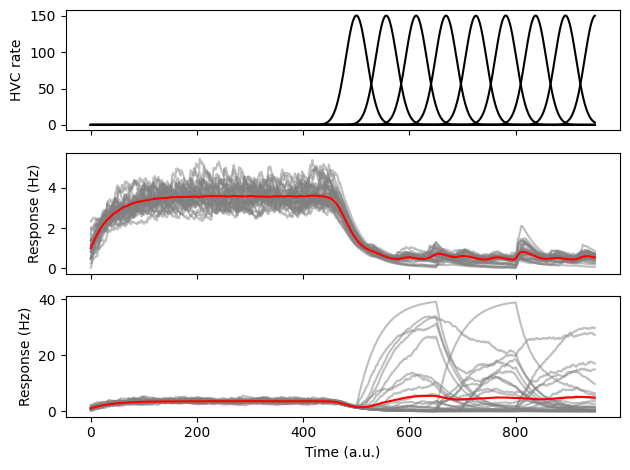

In [29]:
fig, ax = plt.subplots(3, sharex='all')
i, j = 0, int(tsyl_end[2,0])
ax[0].plot(rH[i:j], c='k')
ax[1].plot(test0[0][i:j,:30], c='grey', alpha=0.5)
ax[1].plot(test0[0][i:j,:].mean(axis=-1), c='r')
ax[2].plot(test_sp[0][i:j,:30], c='grey', alpha=0.5)
ax[2].plot(test_sp[0][i:j,:].mean(axis=-1), c='r')
ax[0].set(ylabel='HVC rate')
ax[1].set(ylabel='Response (Hz)')
ax[2].set(xlabel='Time (a.u.)', ylabel='Response (Hz)')
fig.tight_layout()

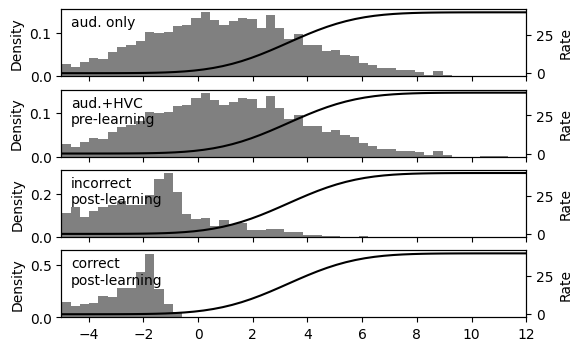

In [30]:
fig, ax = plt.subplots(4, sharex='all', figsize=(6, 4))
labels = ('aud. only', 'aud.+HVC\npre-learning',
          'incorrect\npost-learning', 'correct\npost-learning')
ys = (syl.flatten(), (syl+(Ws[0][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten(), 
      (syl[idx_si]+(Ws[-1][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten(),
      (syl+(Ws[-1][:,::N_HVC_per_syl].T-w_inh)*peak_rate).flatten())
kwargs = dict(bins=50, range=(-5, 12), density=True)
for a, ys, l in zip(ax, ys, labels):
    a.hist(ys, color='grey', **kwargs)
    a.set(ylabel='Density')
    a = a.twinx()
    _ = np.linspace(-5, 12)
    a.plot(_, phi(_), c='k')
    a.text(_[1], a.get_ylim()[1]*0.9, l, ha='left', va='top')
    a.set(xlim=_[[0,-1]], ylabel='Rate')

### Mismatch with perturbed patterns

In [31]:
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    eps = rng.standard_normal(size=syl.shape)
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        mean_syl, std_syl = syl.mean(), syl.std()
        syl_ = (syl - mean_syl) / std_syl * (1 - pm) + np.sqrt(pm * (2 - pm)) * eps
        syl_ = syl_ * std_syl + mean_syl
    elif perturb_type == 'ADD':
        syl_ = syl + pm * eps
    else:
        raise NotImplementedError
    aud_ = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_)
    tests.append(net.sim(rE0, rH_, aud_, [], T_test, dt, noise))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], np.abs(syl_ - syl), dim=2))

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 13064.00it/s]


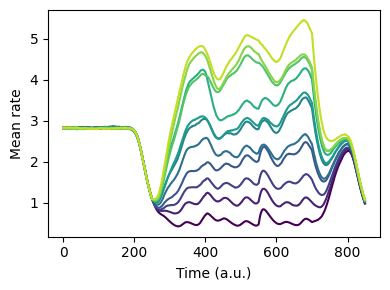

In [32]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[0][T_burn//2:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

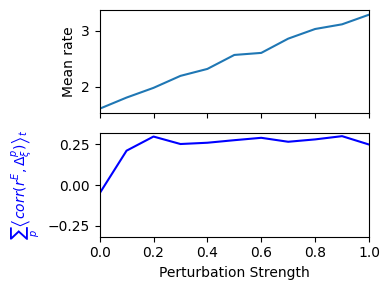

In [33]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
# ax = [*ax, ax[1].twinx()]
ax[0].plot(perturb_param, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x.sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
# ax[2].plot(perturb_param, list(map(lambda x: x.mean(), ovlps)), 
#            color='r', label='Overlap')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \Delta_\xi^p)\right\rangle_t$', c='b')
# ax[2].set_ylabel(r'$\left\langle r^E \cdot \xi^p\right\rangle_{t,p}$', c='r')
fig.tight_layout()